In [749]:
import pandapower as pp
import pandapower.networks as nw
import pandapower.plotting as plot
import matplotlib.pyplot as plt
import math
import numpy as np
import copy
import pandapower.shortcircuit as sc
from matplotlib.transforms import BlendedGenericTransform
#from pandapower.plotting import simple_plot, simple_plotly, pf_res_plotly

# Predefined network of IEEE 4gs bus system 
net = pp.networks.case4gs()
#plot.simple_plot(net)

In [750]:
####Shunt FACTS device (bus 1)
#MV bus
bus_SVC = pp.create_bus(net, name='MV SVCtrafo bus', vn_kv=69, type='n', geodata=(-2,2.5), zone=2, max_vm_pu=1.1,
                        min_vm_pu=0.9)
#Trafo
trafoSVC = pp.create_transformer_from_parameters(net, hv_bus=1, lv_bus=4, in_service=True, 
                                                name='trafoSVC', sn_mva=110, vn_hv_kv=230 , vn_lv_kv=69, 
                                                vk_percent=12, vkr_percent=0.26, pfe_kw=55, i0_percent=0.06,
                                                shift_degree=0, tap_side='hv', tap_neutral=0, tap_min=-9, tap_max=9,
                                                tap_step_percent=1.5, tap_step_degree=0, tap_phase_shifter=False) 
#Breaker between grid HV bus and trafo HV bus to connect buses
sw_SVC = pp.create_switch(net, bus=1, element=0, et='t', type='CB', closed=False)
#Shunt devices connected with MV bus
shuntDev = pp.create_shunt(net, bus_SVC, 1, in_service=True, name='Shunt Device', step = 1)

In [751]:
####Series device (at line 3, in middle between bus 2 and 3)
#Add intermediate buses for bypass and series compensation impedance
bus_SC1 = pp.create_bus(net, name='SC bus 1', vn_kv=230, type='n', geodata=(-1,3.1), zone=2, max_vm_pu=1.1, min_vm_pu=0.9)
bus_SC2 = pp.create_bus(net, name='SC bus 2', vn_kv=230, type='n', geodata=(-1,3.0), zone=2, max_vm_pu=1.1, min_vm_pu=0.9)
sw_SC_bypass = pp.create_switch(net, bus=5, element=6, et='b', type='CB', closed=True)
imp_SC = pp.create_impedance(net, from_bus=5, to_bus=6, rft_pu=0.000001272, xft_pu=-0.0636,
                             rtf_pu=0.000001272, xtf_pu=-0.0636, sn_mva=250, in_service=True) #Just some default values
#Adjust orginal Line 3 to connect to new buses instead.
net.line.at[3, ['length_km', 'to_bus', 'name']] = [0.5, 5, 'line1_SC']                        
lineSC2 = pp.create_line_from_parameters(net, name='line2_SC', c_nf_per_km=net.line.at[3,'c_nf_per_km'],
                       df=net.line.at[3, 'df'], from_bus=6, g_us_per_km=net.line.at[3, 'g_us_per_km'],
                       in_service=net.line.at[3, 'in_service'], length_km=0.5, max_i_ka=net.line.at[3, 'max_i_ka'],
                       max_loading_percent=net.line.at[3, 'max_loading_percent'], parallel=net.line.at[3, 'parallel'],
                       r_ohm_per_km=net.line.at[3, 'r_ohm_per_km'], std_type=net.line.at[3, 'std_type'], to_bus=3, 
                       type=net.line.at[3, 'type'], x_ohm_per_km=net.line.at[3, 'x_ohm_per_km'])

In [752]:
###EXCHANGE PV GEN INTO SGEN
pp.runpp(net)
net.gen.drop(index=[0], inplace= True) #Drop PV generator
sgen_nom_p_mw = net.res_gen.p_mw # Set generator nominal output as output of generator during IEEE nominal setup
sgen_nom_q_mvar = net.res_gen.q_mvar
sgen_nom_s_mva = math.sqrt(sgen_nom_p_mw**2 + sgen_nom_q_mvar**2)
sgen = pp.create_sgen(net, 3, p_mw=sgen_nom_p_mw, q_mvar=sgen_nom_q_mvar, name='static generator', scaling=1, 
                      sn_mva=sgen_nom_s_mva)
sgen_nom_s_mva

366.1427027318814

In [753]:
##Function for transition from reference power to reactance of "TCSC"
def K_x_comp_pu(net, x_line_pu, p_ref_pu):
    network = net
    k_x_comp_max_ind = 0.2 #maximum inductive reactance compensation of the line
    k_x_comp_max_cap = -0.8 #maximum capacitive reactance compensation of the line
    v_s_pu = net.res_bus.vm_pu[3]
    v_r_pu = net.res_bus.vm_pu[2]
    delta_deg = net.res_bus.va_degree[3] - net.res_bus.va_degree[2]
    k_x_comp = ((v_s_pu * v_r_pu * math.sin(math.radians(delta_deg))) / (p_ref_pu* x_line_ohm)) - 1
    #print(k_x_comp)
    if k_x_comp > k_x_comp_max_ind:
        k_x_comp = k_x_comp_max_ind
    if k_x_comp < k_x_comp_max_cap:
        k_x_comp = k_x_comp_max_cap
    return k_x_comp

p_ref_pu = 1
S_base = 100e6
V_base = 230e3
x_base = pow(V_base,2) / S_base
x_line_ohm = net.line.x_ohm_per_km[3]
x_line_pu = x_line_ohm / x_base # Can take one since this line is divivded into 
                                              # 2 identical lines with length 0.5 km  
k_x_comp_pu = K_x_comp_pu(net, x_line_pu, p_ref_pu)
print(k_x_comp_pu)

-0.8


In [754]:
## Function for transition from reference parameter to reactive power output of shunt device
def Shunt_q_comp(net, v_ref_pu):
    v_bus_pu = net.res_bus.vm_pu[1]
    k = 25 #Coefficient for transition, tuned to hit 1 pu with nominal IEEE
    q_rated = 100 #Mvar
    q_min = -q_rated
    q_max = q_rated
    q_comp = k*q_rated*(v_bus_pu-v_ref_pu)    
    
    if q_comp > q_max:
        q_comp = q_max
    if q_comp < q_min:
        q_comp = q_min
    
    return q_comp

q_comp = Shunt_q_comp(net, 1)
q_comp

-43.94691498926212

In [755]:
##Function for nose curve
def NoseCurve(p_low_pu, p_high_pu, bus_index, net, x_line_pu):
    
    network = copy.deepcopy(net) #So not changing anything in actual network
    fig = plt.figure()
    
    l_arr = np.linspace(p_low_pu, p_high_pu, 100)
    l_len = len(l_arr)
    v_res = np.zeros(l_len)
    l_ind = bus_index
    l_p_mw = network.load.p_mw[l_ind]
    l_q_mvar = network.load.q_mvar[l_ind]
    
    for ind in range(l_len):
        # Load scaling
        l_scaling = l_arr[ind]
        network.load.p_mw[l_ind] = l_p_mw*l_scaling
        network.load.q_mvar[l_ind] = l_q_mvar*l_scaling
        pp.runpp(network)
        
        # Shunt compensation
        v_ref_pu = 1
        q_comp = Shunt_q_comp(network, v_ref_pu)
        network.shunt.q_mvar =  q_comp
        #print(network.shunt.q_mvar)
        
        # Series compensation
        p_ref_pu = 15.7
        k_x_comp_pu = K_x_comp_pu(network, x_line_pu, p_ref_pu)
        network.impedance.loc[0, ['xft_pu','xtf_pu']] = x_line_pu * k_x_comp_pu
        #print(x_line_pu * k_x_comp_pu)
        
        pp.runpp(network)
        v_res[ind] = network.res_bus.vm_pu[l_ind]

    plt.plot(l_arr, v_res, figure=fig)
    plt.ylabel('Bus Voltage [pu]')
    plt.xlabel('Active power [pu]')
    plt.grid(True)
    
    return [fig, v_res, l_arr]

In [756]:
##Function to merge figures into 1
def MergeFig(v_res1, l_arr1, label1, v_res2, l_arr2, label2, v_res3, l_arr3, label3):
    fig = plt.figure()
    plt.plot(l_arr1, v_res1, figure=fig, label=label1)
    plt.plot(l_arr2, v_res2, figure=fig, label=label2)
    plt.plot(l_arr3, v_res3, figure=fig, label=label3)
    plt.ylabel('Bus Voltage [pu]')
    plt.xlabel('Active power [pu]')
    plt.grid(True)
    plt.legend()
    return fig    

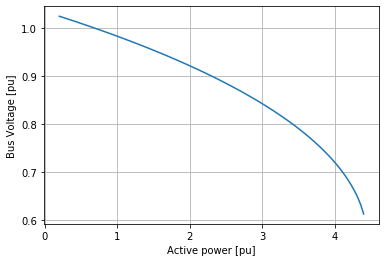

In [757]:
NoseCurve1 = NoseCurve(0.2,4.4,1, net, x_line_pu)

In [758]:
net.res_bus

,vm_pu,va_degree,p_mw,q_mvar
0,1.000000,0.000000,-136.806814,-83.441420
1,0.982421,-0.977077,170.000000,105.350000
2,0.969031,-1.871668,200.000000,123.940000
3,1.020000,1.521408,-238.000000,-131.904101
4,NaN,NaN,0.000000,0.000000
5,0.995088,-0.143270,0.000000,0.000000
6,0.995088,-0.143270,0.000000,0.000000


In [759]:
net.res_line.loading_percent

0    20.182829
1    47.877698
2    61.462187
3    49.274683
4    48.021956
Name: loading_percent, dtype: float64

In [760]:
# Enabling shunt device, true means enabled
net.switch.closed[0] = True
net.trafo.tap_pos[0] = 0

In [761]:
# Enabling the series compensation, False means enabled
net.switch.at[1, 'closed'] = True

In [762]:
pp.runpp(net)
net.res_line.loading_percent

0    20.395436
1    47.948374
2    61.542359
3    49.219509
4    47.971185
Name: loading_percent, dtype: float64

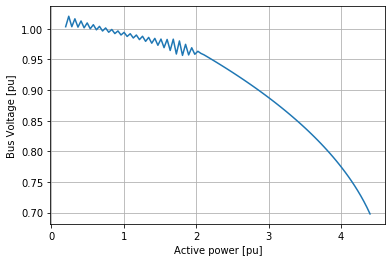

In [763]:
NoseCurve2 = NoseCurve(0.2,4.4,1, net, x_line_pu)

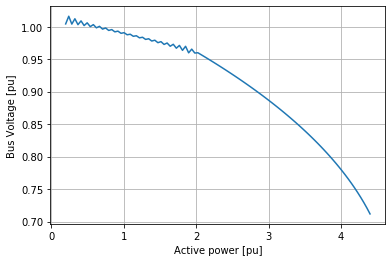

In [764]:
net.switch.at[1, 'closed'] = False
NoseCurve3 = NoseCurve(0.2,4.4,1, net, x_line_pu)

In [765]:
#Shunt
v_ref_pu = 1
q_comp = Shunt_q_comp(net, v_ref_pu)
net.shunt.q_mvar =  q_comp

#Series
p_ref_pu = 15.7
k_x_comp_pu = K_x_comp_pu(net, x_line_pu, p_ref_pu)
net.impedance.loc[0, ['xft_pu','xtf_pu']] = x_line_pu * k_x_comp_pu

pp.runpp(net)
net.res_bus

,vm_pu,va_degree,p_mw,q_mvar
0,1.000000,0.000000,-136.842253,-31.577712
1,0.996663,-1.540621,170.000000,105.350000
2,0.977857,-1.647186,200.000000,123.940000
3,1.026426,0.690087,-238.000000,-131.904101
4,1.047995,-1.606338,0.000000,-49.344853
5,1.010933,0.214733,0.000000,0.000000
6,0.995109,-1.149199,0.000000,0.000000


In [766]:
net.res_line.loading_percent

0    21.273368
1    38.677087
2    52.706513
3    57.726131
4    56.295284
Name: loading_percent, dtype: float64

In [767]:
## LOAD INCREASE AT BUS 3!
# Load scaling
l_ind = 3
l_p_mw = net.load.p_mw[l_ind]
l_q_mvar = net.load.q_mvar[l_ind]
l_scaling = 1.2
net.load.p_mw[l_ind] = l_p_mw*l_scaling
net.load.q_mvar[l_ind] = l_q_mvar*l_scaling

In [768]:
#Series
p_ref_pu = 15.7
k_x_comp_pu = K_x_comp_pu(net, x_line_pu, p_ref_pu)
net.impedance.loc[0, ['xft_pu','xtf_pu']] = x_line_pu * k_x_comp_pu

pp.runpp(net)
net.res_bus

,vm_pu,va_degree,p_mw,q_mvar
0,1.000000,0.000000,-152.606547,-41.317751
1,0.993542,-1.736100,170.000000,105.350000
2,0.975518,-1.809831,200.000000,123.940000
3,1.021216,0.373733,-222.000000,-121.988101
4,1.044713,-1.801817,0.000000,-49.036240
5,1.006731,-0.070530,0.000000,0.000000
6,0.991791,-1.348395,0.000000,0.000000


In [769]:
net.res_line.loading_percent

0    24.117669
1    42.495494
2    49.448264
3    54.171552
4    52.731487
Name: loading_percent, dtype: float64

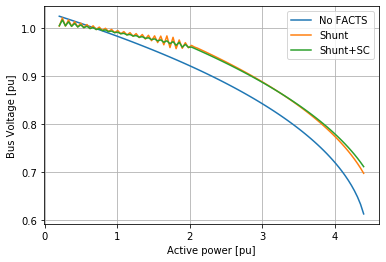

In [770]:
figMerge1 = MergeFig(NoseCurve1[1], NoseCurve1[2], 'No FACTS', 
                     NoseCurve2[1], NoseCurve2[2], 'Shunt',
                     NoseCurve3[1], NoseCurve3[2], 'Shunt+SC')